[A Resnet34 backbone](https://segmentation-models.readthedocs.io/en/latest/api.html#unet) is used as the encoder part of U-Net. Because this backbone only accept 3-channel images, 3 bands were chosen among all the 8 bands.

Bands: 


1.   Land surface temperature (LST) (chosen)
2.   NDBI
3.   NDVI (chosen)
4.   Blue
5.   Green
6.   Blue
7.   NIR
8.   Land cover (chosen)




# Data Preparation
Data preparation can be split into three steps:
 

1.   Import satellite images and corresponding masks, and choose the bands want to use.
2.   Create image chips: cropping satellite images into smaller regular sizes (128\*128, 256\*256, 512\*512, etc).
3.   Balance data: downsampling the images with high proportion of backgrounds.



## Import images

In [ ]:
!pip install pyrsgis
!pip install rasterio
!pip install patchify
!pip install focal-loss
!pip install segmentation_models

In [1]:
import os
import rasterio
import numpy as np
%matplotlib inline
from osgeo import gdal

# set the directory and file 
dir = '/content/drive/MyDrive/ThesisProject/Data'
image_file_name = 'bands_lst_ndbi_ndvi_r_g_b_nir_lc.tif'
park_file_name = 'park_rst.tif'

def read_file(city):  
  '''
  read the satellite image file and corresponding mask as np.array of a given city
  '''
 
  # read image file
  image_file_path = os.path.join(dir, city, image_file_name)
  image = gdal.Open(image_file_path)
  image_array = image.ReadAsArray()
  image_array = np.transpose(image_array, [1, 2, 0])  # transpose the first and third axis
  image_array[np.isnan(image_array)] = 0              # replace nan with 0

  # read park file
  park_file_path = os.path.join(dir, city, park_file_name)
  park = gdal.Open(park_file_path)
  park_array = park.ReadAsArray()
  park_array = np.expand_dims(park_array, axis = 2) # expand from 2D to 3D
  park_array[np.isnan(park_array)] = 0              # replace nan with 0
  park_array[park_array > 1] = 1                    # repalce values greater than 1 with 1

  return image_array, park_array

In [2]:
# read image and mask files of cities
image_array_SF, park_array_SF = read_file('San_Francisco')
image_array_St, park_array_St = read_file('Seattle')
image_array_Dv, park_array_Dv = read_file('Denver')
#image_array_Ph, park_array_Ph = read_file('Philadelphia') # used for testing on new cities

print(image_array_SF.shape, park_array_SF.shape)
print(image_array_St.shape, park_array_St.shape)
print(image_array_Dv.shape, park_array_Dv.shape)
#print(image_array_Ph.shape, park_array_Ph.shape)

(1385, 1452, 8) (1385, 1452, 1)
(2659, 1464, 8) (2659, 1464, 1)
(3300, 4132, 8) (3300, 4132, 1)


In [3]:
# get three bands from image_array: NDBI, NDVI, and land cover
image_array_SF = image_array_SF[:, :, (0, 2, 7)]
image_array_St = image_array_St[:, :, (0, 2, 7)]
image_array_Dv = image_array_Dv[:, :, (0, 2, 7)]
#image_array_Ph = image_array_Ph[:, :, (0, 2, 7)]

## Get image chips and balance data

In [2]:
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# define a function to crop images and corresponding masks into proper size
def create_chips(image_file, park_file, patch_size, step):
  '''
  This function creates chips for satellite image and corresponding masks
  Input  - image_file: np.array of satellite image
         - park_file: np.array of mask
         - patch_size: size of output chips
         - step: stride when cropping
  Output - one np.array for chips of satellite image, another one for mask
  '''
 
  scaler = MinMaxScaler() # scale to the min = 0, and max = 1
  
  # crop image_file
  image_dataset = []
  patches_img = patchify(image_file, (patch_size, patch_size, image_file.shape[2]), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,:,:]   
      # scale to min = 0, max = 1          
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      image_dataset.append(single_patch_img) 
  image_dataset = np.array(image_dataset)

  # cropping park_file
  park_dataset = []
  patches_img = patchify(park_file, (patch_size, patch_size, park_file.shape[2]), step=step)  
  
  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):      
      single_patch_img = patches_img[i,j,:,:]
      # scale to min = 0, max = 1 
      single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
      single_patch_img = single_patch_img[0] # Drop the extra unecessary dimension that patchify adds.                               
      park_dataset.append(single_patch_img)
  park_dataset = np.array(park_dataset)
  
  return image_dataset, park_dataset

In [3]:
def remove_images(image_dataset, park_dataset, threshold):
  '''
  This function remove images and corresponding masks with high proportion of backgrounds
  Input  - image_dataset, park_dataset: np.array of chips of satellite images and masks
         - threshold: if proportion of backgrounds is higher than threshold, the chips will be removed
  Output - balanced array without those chips
  '''
  
  # get the id of images to remove
  id_to_remove = []
  for i in range(len(park_dataset)):
    mask = park_dataset[i, :, :, 0]
    tot_pixel = mask.size
    background_pixel = np.count_nonzero(mask == 0)
    if background_pixel > tot_pixel * threshold:
      id_to_remove.append(i)
  
  # get the balanced dataset
  image_dataset_balanced = []
  park_dataset_balanced = []
  for i in range(len(image_dataset)):
    if not(i in id_to_remove):
      image = image_dataset[i]
      park = park_dataset[i]
      image_dataset_balanced.append(image)
      park_dataset_balanced.append(park)
  image_dataset_balanced = np.array(image_dataset_balanced)
  park_dataset_balanced = np.array(park_dataset_balanced)

  return image_dataset_balanced, park_dataset_balanced

In [6]:
# get the balanced dataset of cities
image_dataset_SF, park_dataset_SF = create_chips(image_array_SF, park_array_SF, patch_size=256, step=32)
image_dataset_SF_balanced, park_dataset_SF_balanced = remove_images(image_dataset_SF, park_dataset_SF, 0.9)
del image_dataset_SF, park_dataset_SF  # delete variables to save memory

image_dataset_St, park_dataset_St = create_chips(image_array_St, park_array_St, patch_size=256, step=32)
image_dataset_St_balanced, park_dataset_St_balanced = remove_images(image_dataset_St, park_dataset_St, 0.9)
del image_dataset_St, park_dataset_St

image_dataset_Dv, park_dataset_Dv = create_chips(image_array_Dv, park_array_Dv, patch_size=256, step=48)
image_dataset_Dv_balanced, park_dataset_Dv_balanced = remove_images(image_dataset_Dv, park_dataset_Dv, 0.9)
del image_dataset_Dv, park_dataset_Dv

#image_dataset_Ph, park_dataset_Ph = create_chips(image_array_Ph, park_array_Ph, patch_size=256, step=50)
#image_dataset_Ph_balanced, park_dataset_Ph_balanced = remove_images(image_dataset_Ph, park_dataset_Ph, 0.9)
#del image_dataset_Ph, park_dataset_Ph

print(image_dataset_SF_balanced.shape, park_dataset_SF_balanced.shape)
print(image_dataset_St_balanced.shape, park_dataset_St_balanced.shape)
print(image_dataset_Dv_balanced.shape, park_dataset_Dv_balanced.shape)
#print(image_dataset_Ph_balanced.shape, park_dataset_Ph_balanced.shape)

(632, 256, 256, 3) (632, 256, 256, 1)
(693, 256, 256, 3) (693, 256, 256, 1)
(1409, 256, 256, 3) (1409, 256, 256, 1)


In [7]:
# pool cities together
image_dataset = np.concatenate([image_dataset_SF_balanced, image_dataset_St_balanced, 
                                image_dataset_Dv_balanced], axis = 0)
print(image_dataset.shape)
del image_dataset_SF_balanced, image_dataset_St_balanced, image_dataset_Dv_balanced

park_dataset = np.concatenate([park_dataset_SF_balanced, park_dataset_St_balanced, 
                               park_dataset_Dv_balanced], axis = 0)
print(park_dataset.shape)
del park_dataset_SF_balanced, park_dataset_St_balanced, park_dataset_Dv_balanced

(2734, 256, 256, 3)
(2734, 256, 256, 1)


In [8]:
image_dataset[image_dataset > 1] = 1  # replace some wired values like 1.000001 with 1
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", park_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Min pixel value in image is: ", image_dataset.min())
print("Labels in the mask are : ", np.unique(park_dataset))
print("Number of cell with value 1: ", np.count_nonzero(park_dataset == 1))
print("Number of cell with value 0: ", np.count_nonzero(park_dataset == 0))

Image data shape is:  (2734, 256, 256, 3)
Mask data shape is:  (2734, 256, 256, 1)
Max pixel value in image is:  1.0
Min pixel value in image is:  0.0
Labels in the mask are :  [0. 1.]
Number of cell with value 1:  47579476
Number of cell with value 0:  131595948


# Build training and test set

## Split and preprocess to fit model architecture

In [9]:
# train-validation split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, park_dataset, 
                                                    test_size = 0.15, random_state = 42)

del image_dataset, park_dataset

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2323, 256, 256, 3) (411, 256, 256, 3)
(2323, 256, 256, 1) (411, 256, 256, 1)


In [10]:
# preprocess input to fit model architecture
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras
import tensorflow
from keras.layers import Input, Conv2D
from keras.models import Model

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE) # get the preprocessing function
X_train1 = preprocess_input(X_train)
X_test1 = preprocess_input(X_test)
print(X_train1.shape, X_test1.shape)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
(2323, 256, 256, 3) (411, 256, 256, 3)


In [26]:
# turn park_dataset into categorical (one-hot encoding to fit the model architecture)
from tensorflow.keras.utils import to_categorical

# y_train
train_masks_cat = to_categorical(y_train, num_classes=2)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 2))

# y_test
test_masks_cat = to_categorical(y_test, num_classes=2)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], 2))

print(y_train_cat.shape, y_test_cat.shape)

(2323, 256, 256, 2) (411, 256, 256, 2)


## Data augmentation
Data augmentation was performed to expand image dataset and to reduce overfitting. The techniques chosen were rotation, flip, and shift.

In [29]:
# set parameters of data augmentation
seed=24
from keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict(rotation_range=20, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.1, 
                         #zoom_range=[0.5, 2], 
                         #brightness_range=[0.7, 1.3],
                         horizontal_flip=True, 
                         vertical_flip=True, 
                         fill_mode='reflect',
                         preprocessing_function = preprocess_input)

mask_data_gen_args = dict(rotation_range=20, 
                          width_shift_range=0.1, 
                          height_shift_range=0.1, 
                          shear_range=0.1, 
                          #zoom_range=[0.5, 2], 
                          #brightness_range=[0.7, 1.3],
                          horizontal_flip=True, 
                          vertical_flip=True, 
                          fill_mode='reflect',
                          preprocessing_function = lambda x: np.where(x > 0, 1, 0).astype(x.dtype)) 

# set the batch size of image generator
batch_size= 8

# image generator (X_train and X_test)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train1, augment=True, seed=seed)

image_generator = image_data_generator.flow(X_train1, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test1, seed=seed, batch_size=batch_size) 

# mask generator (y_train and y_test)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train_cat, augment=True, seed=seed)

mask_generator = mask_data_generator.flow(y_train_cat, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test_cat, seed=seed, batch_size=batch_size)

# put image generator and mask generator together
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

train_generator = my_image_mask_generator(image_generator, mask_generator)
validation_generator = my_image_mask_generator(valid_img_generator, valid_mask_generator)

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (2323, 256, 256, 2) (2 channels).
  ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (2323, 256, 256, 2) (2 channels).
  str(self.x.shape[channels_axis]) + ' channels).')
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 chann

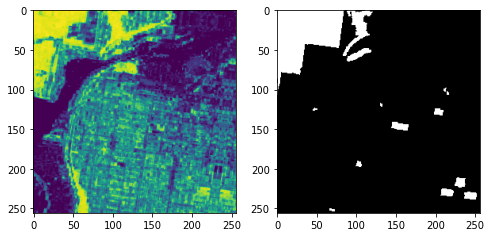

In [32]:
# sanity check
import matplotlib.pyplot as plt

x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(8, 4))
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,1])
    
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,1], cmap = 'gray')
    plt.show()

# Model training and evaluation

In [33]:
# build model (U-Net with resnet34 backbone, pretrained on imagenet)
sm.set_framework('tf.keras')
sm.framework()

n_classes = 2
activation = 'sigmoid'  # the activation function used for the output layer

# set loss function and metrics
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
loss = sm.losses.binary_focal_dice_loss
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# set BACKBONE
BACKBONE = 'resnet34'

# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation)

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, loss = loss, metrics=metrics)
#model.summary()

In [34]:
# set hyperparameters
batch_size = 16
steps_per_epoch = len(X_train1)//batch_size  # for generator, you need to specify the steps if using generator
validation_steps = len(X_test1)//batch_size  # for generator
print(steps_per_epoch, validation_steps)

145 25


Epoch 1/50
145/145 [==============================] - 30s 204ms/step - loss: 0.3167 - accuracy: 0.8660 - iou_score: 0.7110 - f1-score: 0.8226 - val_loss: 0.7596 - val_accuracy: 0.7597 - val_iou_score: 0.3851 - val_f1-score: 0.4413
Epoch 2/50
145/145 [==============================] - 30s 204ms/step - loss: 0.3061 - accuracy: 0.8749 - iou_score: 0.7201 - f1-score: 0.8278 - val_loss: 0.6825 - val_accuracy: 0.7051 - val_iou_score: 0.4168 - val_f1-score: 0.5316
Epoch 3/50
145/145 [==============================] - 30s 205ms/step - loss: 0.2704 - accuracy: 0.8895 - iou_score: 0.7495 - f1-score: 0.8497 - val_loss: 0.6207 - val_accuracy: 0.5810 - val_iou_score: 0.4120 - val_f1-score: 0.5776
Epoch 4/50
145/145 [==============================] - 30s 204ms/step - loss: 0.2556 - accuracy: 0.8989 - iou_score: 0.7641 - f1-score: 0.8598 - val_loss: 0.6081 - val_accuracy: 0.6317 - val_iou_score: 0.4651 - val_f1-score: 0.6267
Epoch 5/50
145/145 [==============================] - 29s 203ms/step - loss:

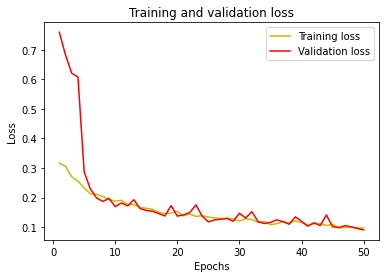

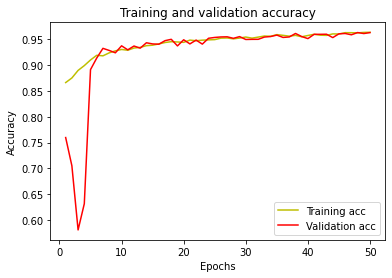

In [36]:
# model training (with data augmentation)
history1 = model.fit(train_generator, batch_size=16, epochs=50,  steps_per_epoch = steps_per_epoch,
                     validation_steps = validation_steps, verbose=1, validation_data = validation_generator)

# plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt

loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [37]:
# Metrics
loss, acc, IoU, f_score = model.evaluate(X_test1, y_test_cat, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("f_score is ", f_score)

Loss is  0.09274120628833771
Accuracy is  0.9650859832763672
IoU is  0.9120901823043823
f_score is  0.9534485340118408


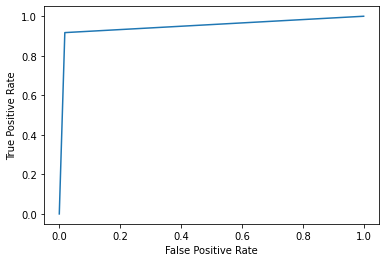

AUC is  0.9495325810968099


In [38]:
# plot ROC curve
from sklearn.metrics import roc_curve

# get prediction for test set
y_pred = model.predict(X_test1)
y_pred_argmax = np.argmax(y_pred, axis=3) # get the max value of the 4th axis, because of one-hot encoding
y_test_cat_argmax = np.argmax(y_test_cat, axis=3)  # get the max of the 4th axis of y_test_cat

# change to binary type
y_pred_argmax_raveled = y_pred_argmax.ravel()  # before set type, flatten the array first
y_test_cat_argmax_raveled = y_test_cat_argmax.ravel()

y_pred_argmax_raveled = y_pred_argmax_raveled.astype(int)
y_test_cat_argmax_raveled = y_test_cat_argmax_raveled.astype(int)

FPR, TPR, thresholds = roc_curve(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

# create ROC curve and AUC
plt.plot(FPR,TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

from sklearn.metrics import auc
auc = auc(FPR, TPR)
print("AUC is ", auc)

In [39]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)
recall = recall_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

print("Precision is", precision)
print("Recall is ", recall)

Precision is 0.9464990501920224
Recall is  0.9172187023199098


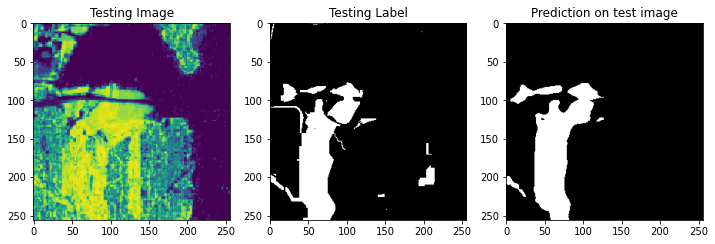

In [40]:
# Test some random images
import random

test_img_number = random.randint(0, len(X_test1))
test_img = X_test1[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,1])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()

In [41]:
# save model
model.save('/content/drive/MyDrive/ThesisProject/model-resunet-027-SFStDv.h5')

# Test on unseen images

In [4]:
# import datasets, create chips, and remove samples with high proportion of backgrounds
dir = '/content/drive/MyDrive/ThesisProject/Data'
image_file_name = 'bands_lst_ndbi_ndvi_r_g_b_nir_lc.tif'
park_file_name = 'park_rst.tif'

image_array_Ph, park_array_Ph = read_file('Philadelphia')
image_array_Ph = image_array_Ph[:, :, (0, 2, 7)]

image_dataset_Ph, park_dataset_Ph = create_chips(image_array_Ph, park_array_Ph, patch_size=256, step=80)
image_dataset_Ph_balanced, park_dataset_Ph_balanced = remove_images(image_dataset_Ph, park_dataset_Ph, 0.9)

del image_dataset_Ph, park_dataset_Ph

In [5]:
print(image_dataset_Ph_balanced.shape, park_dataset_Ph_balanced.shape)

(542, 256, 256, 3) (542, 256, 256, 1)


In [6]:
# load model
from keras.models import load_model
import tensorflow
import segmentation_models as sm

model1 = load_model('/content/drive/MyDrive/ThesisProject/model-resunet-027-SFStDv.h5', compile = False)

# compile model
LR = 0.0001
optim = tensorflow.keras.optimizers.Adam(LR)
loss = sm.losses.binary_focal_dice_loss 
metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model1.compile(optim, loss, metrics=metrics)

Segmentation Models: using `keras` framework.


In [8]:
# precessing X to fit the model
import segmentation_models as sm
from tensorflow.keras.utils import to_categorical

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
X_test = preprocess_input(image_dataset_Ph_balanced)

# turn y to categorical data
test_masks_cat = to_categorical(park_dataset_Ph_balanced, num_classes=2)
y_test_cat = test_masks_cat.reshape((park_dataset_Ph_balanced.shape[0], 
                                     park_dataset_Ph_balanced.shape[1], 
                                     park_dataset_Ph_balanced.shape[2], 2))
print(X_test.shape, y_test_cat.shape)

(542, 256, 256, 3) (542, 256, 256, 2)


In [9]:
# predict and metrics
loss, acc, IoU, f_score = model1.evaluate(X_test, y_test_cat, verbose = 0)

print("Loss is ", loss)
print("Accuracy is ", acc)
print("IoU is ", IoU)
print("f_score is ", f_score)

Loss is  0.49833908677101135
Accuracy is  0.8286720514297485
IoU is  0.6188222169876099
f_score is  0.7451184988021851


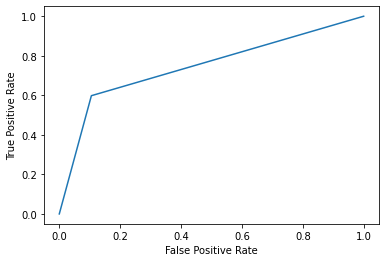

AUC is  0.7463263163201717
Precision is 0.618476111834303
Recall is  0.5980861437960986


In [10]:
# plot ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# get prediction for test set
y_pred = model1.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3) # get the max value of the axis3, because of one-hot encoding
y_test_cat_argmax = np.argmax(y_test_cat, axis=3)  # get the max of the 4th axis of y_test_cat

# change to binary type
y_pred_argmax_raveled = y_pred_argmax.ravel()  # before set type, flatten the array first
y_test_cat_argmax_raveled = y_test_cat_argmax.ravel()

y_pred_argmax_raveled = y_pred_argmax_raveled.astype(int)
y_test_cat_argmax_raveled = y_test_cat_argmax_raveled.astype(int)

FPR, TPR, thresholds = roc_curve(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

# create ROC curve
plt.plot(FPR,TPR)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

auc = auc(FPR, TPR)
precision = precision_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)
recall = recall_score(y_test_cat_argmax_raveled, y_pred_argmax_raveled)

print("AUC is ", auc)
print("Precision is", precision)
print("Recall is ", recall)

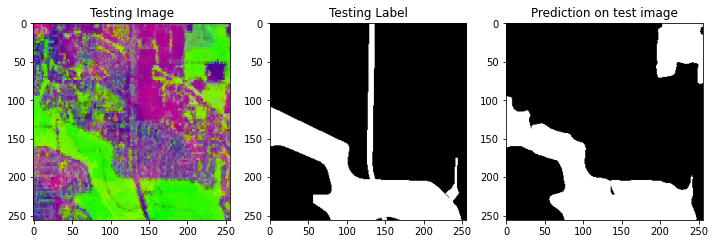

In [13]:
# Test some random images
import random
import matplotlib.pyplot as plt

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = park_dataset_Ph_balanced[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

test_img_input1 = preprocess_input(test_img_input)

test_pred1 = model1.predict(test_img_input1)
test_prediction1 = np.argmax(test_pred1, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,:])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction1, cmap='gray')
plt.show()